# Define AOIs and Calculate Gaze Metrics

After mapping gaze to the environment, e.g. by using the [Reference Image Mapper](https://docs.pupil-labs.com/invisible/explainers/enrichments/#reference-image-mapper), it is a common goal to compare gaze behavior on different objects of interest within the environment. An easy way to facilitate this using the Reference Image Mapper is to define areas of interest (AOIs), also known as regions of interest (ROIs), in the reference image, and to compare them with various gaze metrics like e.g. dwell time. 

In this guide, we will show you how to mark AOIs on a reference image, how to label which AOI a fixation was made on, and how to aggregate metrics from fixation data inside these AOIs.

As an example we will use the recordings and enrichment of the art gallery study available in the [demo workspace](https://cloud.pupil-labs.com/workspace/78cddeee-772e-4e54-9963-1cc2f62825f9/project/cdfde655-3c8a-45c5-b6e2-5d5754d7a4f0/edit). We will address questions like "How many visitors looked at each painting?", "How soon after arriving did visitors look at each painting?", and "How long did visitors look at each painting?".

## Dependencies of this Guide

You can find all code from this guide as well as the used example data [here](https://github.com/pupil-labs/pupil-docs/blob/master/src/invisible/how-tos/advanced-analysis/gaze-metrics-in-aois/). The example data originates from the Reference Image Mapper enrichment called `multiple_paintings_standing` located in the demo workspace [here](https://cloud.pupil-labs.com/workspace/78cddeee-772e-4e54-9963-1cc2f62825f9/project/cdfde655-3c8a-45c5-b6e2-5d5754d7a4f0/enrich?search=multiple_paintings_standing). 

To execute it you need to have the following libraries installed:

```pip install matplotlib pandas opencv-python seaborn```

## Define AOIs in the Reference Image
The reference image `reference_image.jpeg` is located inside the enrichment folder. 

An easy way to define AOIs in the image is to use the `cv2.selectROIs` method from [OpenCV](https://docs.opencv.org/3.4/d7/dfc/group__highgui.html#ga0f11fad74a6432b8055fb21621a0f893).
When executing this method, a window with the reference image will appear.
Mark the AOIs by dragging rectangles over the areas you want your AOIs to cover. Hit the space key after each AOI and once you are done close the selection with the escape key.


In [ ]:
import cv2

# load the reference image
reference_image_bgr = cv2.imread("data/reference_image.jpeg")
reference_image = cv2.cvtColor(reference_image_bgr, cv2.COLOR_BGR2RGB)

# resize the image before labelling AOIs makes the image stay in the screen boundaries
scaling_factor = 0.25
scaled_image = reference_image_bgr.copy()
scaled_image = cv2.resize(
    scaled_image, dsize=None, fx=scaling_factor, fy=scaling_factor
)

# mark the AOIs
scaled_aois = cv2.selectROIs("AOI Annotation", scaled_image)
cv2.destroyAllWindows()

# scale back the position of AOIs
aois = scaled_aois / scaling_factor
print(scaled_aois)

If you want to use the same AOIs as this guide is using, you can uncomment the following code rather than defining your own AOIs.

In [18]:
import numpy as np

# aois = np.array(
#     [[ 512.,  136.,  588.,  572.],
#     [1448.,  700.,  392.,  456.],
#     [1872.,  300.,  652.,  864.],
#     [2584.,  788.,  456.,  576.],
#     [3044.,  928.,  452.,  416.],
#     [3212.,  232.,  504.,  492.],
#     [ 892., 1256., 1636.,  880.],
#     [2628., 1388.,  844.,  648.],
#     [ 696., 2492.,  428.,  476.],
#     [1232., 2304.,  364.,  408.],
#     [1980., 2280.,  556.,  700.],
#     [2576., 2064.,  856.,  936.]]
# )

## Overlaying Areas of Interest on the Reference Image
Now, we visually check whether the AOIs we defined match up with our reference image. We define a `plot_color_patches` function, which we will use throughout the rest of this guide.

In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
sns.set_context("talk")
import pandas as pd
import numpy as np


def plot_color_patches(
    image,
    aoi_positions,
    aoi_values,
    ax,
    alpha=0.3,
    colorbar=False,
    unit_label=""
):
    ax.imshow(image)
    ax.axis("off")

    # normalize patch values
    aoi_values_normed = aoi_values.astype(np.float32)
    aoi_values_normed -= aoi_values_normed.min()
    aoi_values_normed /= aoi_values_normed.max()

    colors = mpl.cm.get_cmap("viridis")

    # for patch_idx, (aoi, value) in enumerate(zip(patch_position, patch_values_normed)):
    for aoi_id, aoi_val in aoi_values_normed.iteritems():
        aoi = aoi_positions[aoi_id]
        ax.add_patch(
            patches.Rectangle(
                aoi,
                *aoi[2:],
                alpha=alpha,
                facecolor=colors(aoi_val),
                edgecolor=colors(aoi_val),
                linewidth=5
            )
        )
        ax.text(aoi[0] + 20, aoi[1] + 120, f"{aoi_id}", color="black")
    
    if colorbar:
        norm = mpl.colors.Normalize(vmin=aoi_values.min(), vmax=aoi_values.max())
        cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=colors), ax=ax)
        cb.set_label(unit_label)

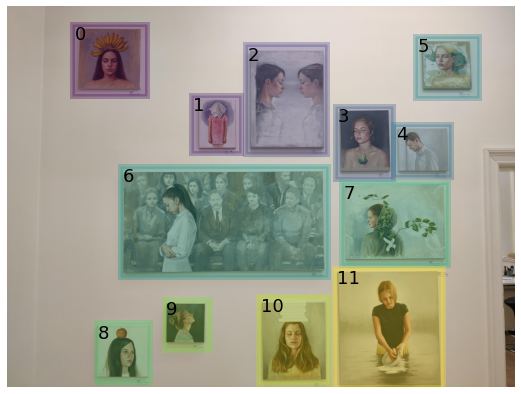

In [20]:
plt.figure(figsize=(10, 7))

aoi_ids = pd.Series(np.arange(len(aois)))
plot_color_patches(reference_image, aois, aoi_ids, plt.gca())

## Map Fixations to AOIs

Next up, we want to match the fixation coordinates to the AOIs. This is comparable to asking for every x/y coordinate pair that defines a fixation if that pair is inside any of the rectangles.

In [21]:
import pandas as pd

fixations = pd.read_csv("data/fixations.csv")
# filter for fixations that are in the reference image
fixations = fixations[fixations["fixation detected in reference image"]]

fixations["AOI"] = None

def check_in_rect(fixation_data, rectangle_coordinates):
    rect_x, rect_y, rect_width, rect_height = rectangle_coordinates
    x_hit = fixation_data["fixation x [px]"].between(rect_x, rect_x + rect_width)
    y_hit = fixation_data["fixation y [px]"].between(rect_y, rect_y + rect_height)
    return x_hit & y_hit

for aoi_id, aoi in enumerate(aois):
    fixations.loc[check_in_rect(fixations, aoi), "AOI"] = aoi_id

fixations.head()

,section id,recording id,fixation id,start timestamp [ns],end timestamp [ns],duration [ms],fixation detected in reference image,fixation x [px],fixation y [px],AOI
0,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,54a0deee-23dd-48f4-806e-6fdb519d6a7c,248,1636035560036503914,1636035560236515914,200,True,2419.0,2138.0,None
1,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,54a0deee-23dd-48f4-806e-6fdb519d6a7c,249,1636035560256651914,1636035560480505914,223,True,2224.0,1717.0,6
2,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,54a0deee-23dd-48f4-806e-6fdb519d6a7c,250,1636035560500491914,1636035560740669914,240,True,2427.0,1559.0,6
3,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,54a0deee-23dd-48f4-806e-6fdb519d6a7c,251,1636035560776494914,1636035560972502914,196,True,1935.0,1119.0,2
4,3cd54e6f-f12e-468c-9a7b-6afffd5f0379,54a0deee-23dd-48f4-806e-6fdb519d6a7c,252,1636035561008557914,1636035561168510914,159,True,2828.0,1668.0,7


You can now see the new column "AOI". This column indicates whether gaze fell inside a given AOI.

## Aggregating Fixation Metrics Inside AOIs

Using the defined AOIs and the mapped fixation data we can now calculate various metrics to compare gaze behaviour on the AOIs.

### AOI Hit Rate

The Hit Rate of an AOI is defined as the proportion of subjects that looked at the AOI at least once. 
A Hit Rate of 100% means, every subject we recorded looked at the AOI, a Hit Rate of 50% indicates that only every second subject looked at the AOI, etc.

In [22]:
hits = fixations.groupby(["recording id", "AOI"]).size() > 0
hit_rate = hits.groupby("AOI").sum() / fixations["recording id"].nunique() * 100

# AOIs that have never been gazed at do not show up in the fixations data
# so we need to set them to 0 manually
for aoi_id in range(len(aois)):
    if not aoi_id in hit_rate.index:
        hit_rate.loc[aoi_id] = 0

hit_rate.sort_index(inplace=True)
hit_rate.head()

AOI
0    100.0
1     60.0
2    100.0
3     40.0
4      0.0
dtype: float64

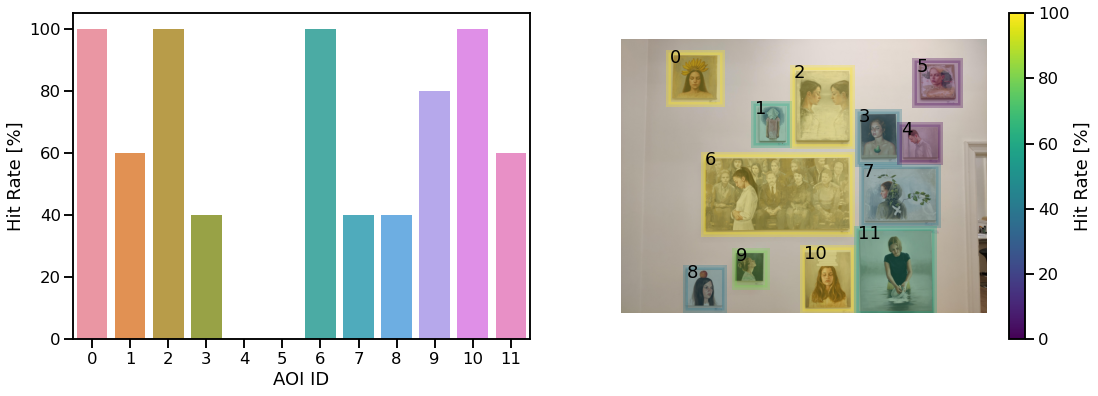

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))

sns.barplot(x=hit_rate.index, y=hit_rate, ax=ax[0])

ax[0].set_xlabel("AOI ID")
ax[0].set_ylabel("Hit Rate [%]");

plot_color_patches(reference_image, aois, hit_rate, ax[1], colorbar=True, unit_label="Hit Rate [%]")

### Time to First Contact
Time to First Contact measures how long it took observers to look at an AOI for the first time. Short times to first contact mean that the observers looked at the AOI early during the section.

We can compute time to first contact as the difference between the time when the first fixation was registered on an AOI and the time when the section started. So first, we need the information when each section started.

In [24]:
sections = pd.read_csv("data/sections.csv")
sections.set_index("section id", inplace=True)

# compute the difference for the respective section
for section_id, start_time in sections["section start time [ns]"].iteritems():
    fixation_indices = fixations[fixations["section id"] == section_id].index
    fixations.loc[fixation_indices, "aligned timestamp [s]"] = (fixations.loc[fixation_indices, "start timestamp [ns]"] - start_time) / 1e9

Next, we aggregate the fixation data by section id and AOI, and extract the lowest value from the "aligned timestamp [s]" column. This is the time when the very first fixation on that AOI appeared in this session.

In [25]:
first_contact = fixations.groupby(["section id", "AOI"])["aligned timestamp [s]"].min().groupby("AOI").mean()
first_contact

AOI
0      5.717699
1      4.106685
2      0.924827
3      4.236960
6      0.880846
7      2.774175
8      9.038934
9      8.679888
10     6.706401
11    20.301783
Name: aligned timestamp [s], dtype: float64

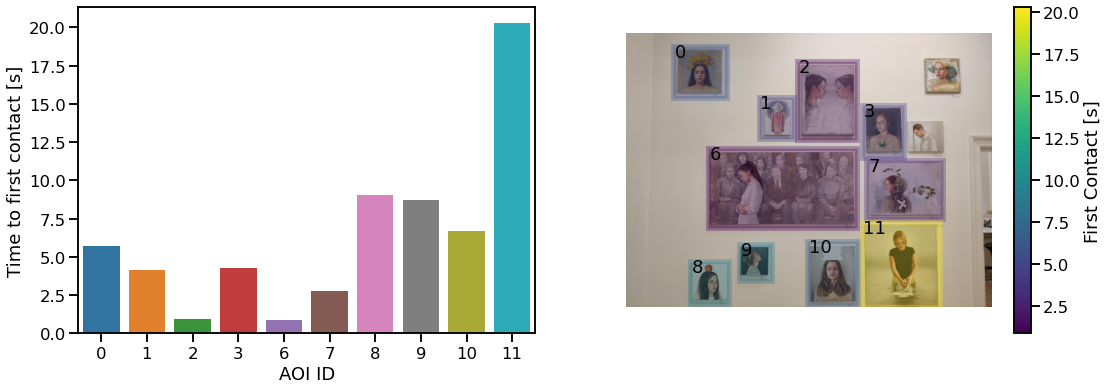

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))

sns.barplot(x=first_contact.index, y=first_contact, ax=ax[0])

ax[0].set_xlabel("AOI ID")
ax[0].set_ylabel("Time to first contact [s]");

plot_color_patches(reference_image, aois, first_contact, ax[1], colorbar=True, unit_label="First Contact [s]")

### Dwell Time

Dwell Time describes the total time an observer has looked at a given AOI on average. We can find the dwell time for each subject by summing up the durations of all fixations we detected, separately for each AOI and subject. Then we calculate the mean over all subjects.

In [27]:
dwell_time = fixations.groupby(["recording id", "AOI"])["duration [ms]"].sum().groupby("AOI").mean()
dwell_time /= 1000

dwell_time.head()

AOI
0    1.0240
1    0.4230
2    1.6328
3    0.8660
6    2.7958
Name: duration [ms], dtype: float64

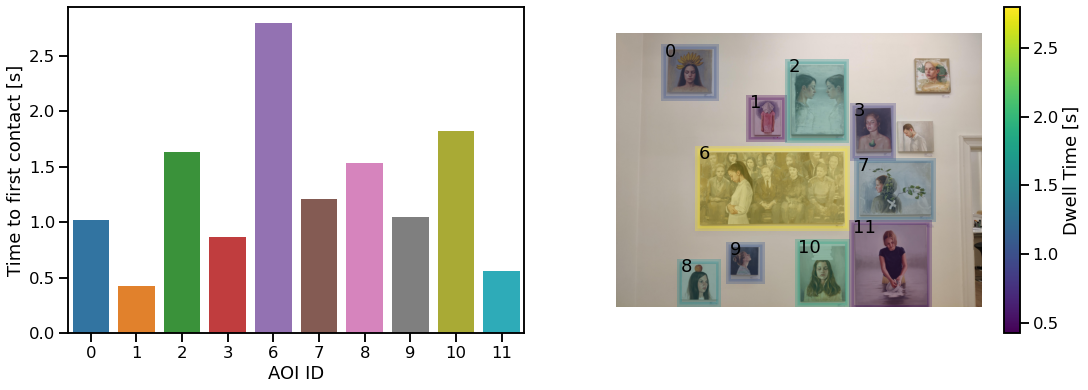

In [28]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))

sns.barplot(x=dwell_time.index, y=dwell_time, ax=ax[0])

ax[0].set_xlabel("AOI ID")
ax[0].set_ylabel("Time to first contact [s]");

plot_color_patches(reference_image, aois, dwell_time, ax[1], colorbar=True, unit_label="Dwell Time [s]")